In [2]:
!pip install folium scikit-learn --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [4]:
url = "https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD"
df = pd.read_csv(url)
df = df[['Date', 'Primary Type', 'Latitude', 'Longitude']]
df.dropna(inplace=True)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Hour'] = df['Date'].dt.hour
df['DayOfWeek'] = df['Date'].dt.day_name()
df = df[df['Primary Type'].notnull()]
df = df.head(10)

/tmp/ipython-input-3474547165.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


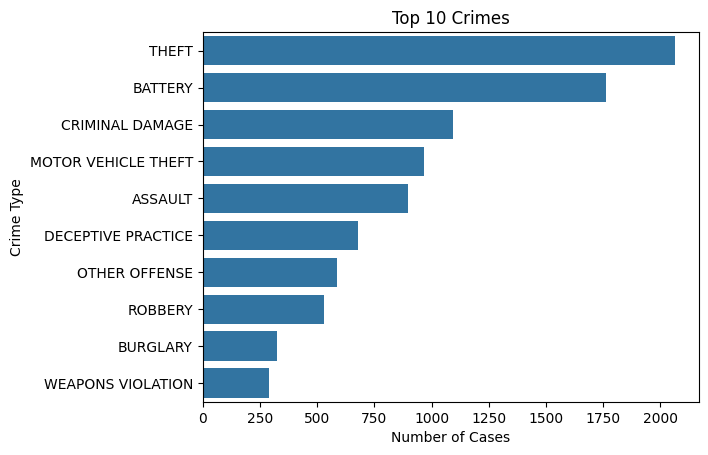

In [ ]:
top_crimes = df['Primary Type'].value_counts().head(10)
sns.barplot(y=top_crimes.index, x=top_crimes.values)
plt.title("Top 10 Crimes")
plt.xlabel("Number of Cases")
plt.ylabel("Crime Type")
plt.show()

In [ ]:
map_crime = folium.Map(location=[41.8781, -87.6298], zoom_start=11)
HeatMap(data=df[['Latitude', 'Longitude']].values).add_to(map_crime)
map_crime.save("crime_heatmap.html")
map_crime

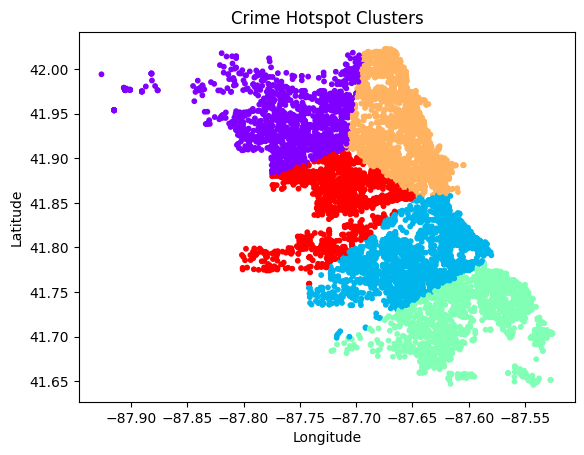

In [ ]:
coords = df[['Latitude', 'Longitude']]
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(coords)
plt.scatter(df['Longitude'], df['Latitude'], c=df['Cluster'], cmap='rainbow', s=10)
plt.title("Crime Hotspot Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
violent = ['BATTERY', 'ASSAULT', 'HOMICIDE', 'ROBBERY']
df['Violent'] = df['Primary Type'].isin(violent).astype(int)
X = df[['Hour', 'Latitude', 'Longitude']]
y = df['Violent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.82      0.75      2038
           1       0.37      0.22      0.27       962

    accuracy                           0.63      3000
   macro avg       0.53      0.52      0.51      3000
weighted avg       0.59      0.63      0.60      3000



In [ ]:
np.random.seed(42)
num_suspects = 200
suspects_df = pd.DataFrame({
    'suspect_id': range(num_suspects),
    'latitude': 41.7 + (42.0 - 41.7) * np.random.rand(num_suspects),
    'longitude': -87.9 + (-87.5 - (-87.9)) * np.random.rand(num_suspects),
    'criminal_history': np.random.randint(0, 10, num_suspects)
})

num_crimes = 100
crimes_df = pd.DataFrame({
    'crime_id': range(num_crimes),
    'latitude': 41.7 + (42.0 - 41.7) * np.random.rand(num_crimes),
    'longitude': -87.9 + (-87.5 - (-87.9)) * np.random.rand(num_crimes),
    'hour': np.random.randint(0, 24, num_crimes),
    'day_of_week': np.random.choice(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], num_crimes)
})

print("Suspects DataFrame:")
display(suspects_df.head())
print("\nCrimes DataFrame:")
display(crimes_df.head())

Suspects DataFrame:


,suspect_id,latitude,longitude,criminal_history
0,0,41.812362,-87.643187,8
1,1,41.985214,-87.866344,0
2,2,41.919598,-87.835349,0
3,3,41.879598,-87.540578,3
4,4,41.746806,-87.657428,8



Crimes DataFrame:


,crime_id,latitude,longitude,hour,day_of_week
0,0,41.970945,-87.767861,4,Sunday
1,1,41.885179,-87.526523,22,Tuesday
2,2,41.994139,-87.896986,0,Wednesday
3,3,41.882426,-87.809867,3,Tuesday
4,4,41.890993,-87.753857,21,Wednesday


In [ ]:
merged_df = pd.merge(suspects_df.assign(key=1), crimes_df.assign(key=1), on='key').drop('key', axis=1)
merged_df['distance'] = np.sqrt((merged_df['latitude_x'] - merged_df['latitude_y'])**2 + (merged_df['longitude_x'] - merged_df['longitude_y'])**2)
merged_df['history_distance_interaction'] = merged_df['criminal_history'] * merged_df['distance']
merged_df['involvement_prob'] = 1 / (1 + np.exp(- (merged_df['criminal_history'] * 0.5 - merged_df['distance'] * 10 + np.random.randn(len(merged_df)) * 0.5))) # Simulate probability
merged_df['involved'] = (merged_df['involvement_prob'] > np.random.rand(len(merged_df))).astype(int) # Simulate binary label
display(merged_df.head())

,suspect_id,latitude_x,longitude_x,criminal_history,crime_id,latitude_y,longitude_y,hour,day_of_week,distance,history_distance_interaction,involvement_prob,involved
0,0,41.812362,-87.643187,8,0,41.970945,-87.767861,4,Sunday,0.201723,1.613782,0.848195,1
1,0,41.812362,-87.643187,8,1,41.885179,-87.526523,22,Tuesday,0.137524,1.100191,0.946315,1
2,0,41.812362,-87.643187,8,2,41.994139,-87.896986,0,Wednesday,0.312181,2.497444,0.566388,0
3,0,41.812362,-87.643187,8,3,41.882426,-87.809867,3,Tuesday,0.180807,1.446454,0.927468,0
4,0,41.812362,-87.643187,8,4,41.890993,-87.753857,21,Wednesday,0.135760,1.086078,0.925686,0


In [ ]:
X = merged_df[['distance', 'criminal_history', 'history_distance_interaction']]
y = merged_df['involved']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (14000, 3)
Shape of X_test: (6000, 3)
Shape of y_train: (14000,)
Shape of y_test: (6000,)


In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("Model training complete.")

Model training complete.


In [ ]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
print("First few predicted probabilities:")
print(y_pred_proba[:10])

First few predicted probabilities:
[1.   0.05 0.98 0.76 1.   1.   0.32 0.   0.64 0.71]
